<a href="https://colab.research.google.com/github/gabrielraya/ddpm-mnist/blob/main/MNIST_Interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation

In [1]:
#@title Autoload files & packages
%load_ext autoreload
%autoreload 2

import os
import time
from IPython.display import clear_output

if 'flag' not in globals():
    flag = True

if flag:
  # load required packages
  !pip install ml-collections

  # clear the output after 2 seconds
  time.sleep(2)
  clear_output(wait=True)


  # Check if the repository is already cloned
  repo_path = 'ddpm-mnist'
  if not os.path.exists(repo_path):
      # Clone the GitHub repo
      !git clone https://github.com/gabrielraya/ddpm-mnist.git
  else:
      print(f"'{repo_path}' already exists. Skipping cloning.")


  # cd to the project folder
  print("Changing to repo directory : ", repo_path)
  os.chdir(repo_path)

  flag=False

Cloning into 'ddpm-mnist'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 86 (delta 37), reused 66 (delta 21), pack-reused 0
Receiving objects: 100% (86/86), 440.85 KiB | 4.50 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Changing to repo directory :  ddpm-mnist


In [2]:
# @title Download checkpoints
# clear the output after 5 seconds


# Choose dataset
dataset = 'MNIST' #@param ['MNIST'] {"type": "string"}

# Define paths
base_dir = f'./results/ddpm_{dataset.lower()}'
zip_file_path = f"{base_dir}/checkpoints.zip"
checkpoint_path = f"{base_dir}/model"

# Check if checkpoints already exist
if os.path.exists(checkpoint_path):
    print("Checkpoints already exist. Skipping download.")
else:
    # Ensure the directory exists
    directory_name = f"results/ddpm_{dataset.lower()}"
    !mkdir -p $directory_name
    !mkdir -p $checkpoint_path
    # Download the file from Google Drive

    !gdown 'https://drive.google.com/uc?id=1kCz8mc-Z_jb0GzKM7jzPWAQjeK55bcxR' -O $zip_file_path

    # Verify download
    if os.path.exists(zip_file_path):
        print(f"Checkpoint for {dataset} has been downloaded successfully!.")

        # Unzip the downloaded file
        !unzip -q $zip_file_path -d $checkpoint_path

        # Remove the downloaded zip file
        !rm $zip_file_path

        print("Files have been successfully extracted and cleaned up.\nYou are now all set up!")

    else:
        print("Download failed.")



Downloading...
From (original): https://drive.google.com/uc?id=1kCz8mc-Z_jb0GzKM7jzPWAQjeK55bcxR
From (redirected): https://drive.google.com/uc?id=1kCz8mc-Z_jb0GzKM7jzPWAQjeK55bcxR&confirm=t&uuid=66d7ae57-3e3b-459d-9d5a-d4376efe898d
To: /content/ddpm-mnist/results/ddpm_mnist/checkpoints.zip
100% 270M/270M [00:04<00:00, 67.4MB/s]
Checkpoint for MNIST has been downloaded successfully!.
Files have been successfully extracted and cleaned up.
You are now all set up!


In [3]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
from datasets import load_data
from plots import visualize_batch, save_image
from datasets import rescaling_inv
from configs.ddpm import mnist as configs

## settings
config = configs.get_config()

# manually changed some settings for quick testing
workdir='./results/ddpm_mnist'
config.training.batch_size = 25
distributed=False
device = config.device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 9912422/9912422 [00:00<00:00, 106425647.30it/s]


Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24130616.30it/s]


Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33493432.44it/s]


Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19782480.55it/s]


Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


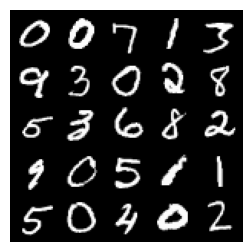

In [4]:
train_loader, test_loader, _ = load_data(config=config, data_path="../datasets", num_workers=3, evaluation=True, distributed=False)
x, _ = next(iter(train_loader))

dataset_name = config.data.dataset
visualize_batch(rescaling_inv(x[:25]), nrow=5, figsize=(3,5))

### Load train model

In [5]:
# Load model and set diffusion class

from models.ddpm import DDPM
from diffusion.losses import get_model_fn
from diffusion.diffusion_lb import GaussianDiffusion

model = DDPM(config)
get_model_fn(model, train=False)

checkpoint_dir = os.path.join(workdir, "model")
ckpt = config.eval.checkpoint
ckpt_dir = os.path.join(checkpoint_dir, "ckpt_{}_checkpoint.pt".format(ckpt))
loaded_state = torch.load(ckpt_dir, map_location=device)
model.load_state_dict(loaded_state['net'])
model.to(config.device)
print()

In [6]:
diffusion = GaussianDiffusion(config.model.beta_min, config.model.beta_max, T=1000)  # defines the diffusion process

### Generate samples

In [7]:
import diffusion.sampling as sampling

sampler_method = sampling.get_sampler(config.sampling.sampler.lower())
sampler = sampler_method(diffusion, model)

100%|██████████| 1000/1000 [01:11<00:00, 13.99it/s]


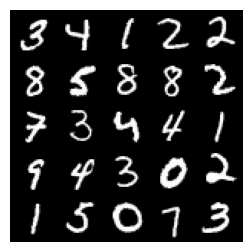

In [8]:
# DDPM samples 1000 denoising steps
C, H, W = config.data.num_channels, config.data.image_size, config.data.image_size
sampling_shape = (config.sampling.generated_batch, C, H, W)

with torch.no_grad():
    uncond_samples = sampling.sampling_fn(config, diffusion, model, sampling_shape, rescaling_inv)
    uncond_samples = torch.clip(uncond_samples * 255, 0, 255).int()

visualize_batch(uncond_samples[:25].cpu(), nrow=5, figsize=(3,5))

100%|██████████| 10/10 [00:00<00:00, 15.23it/s]


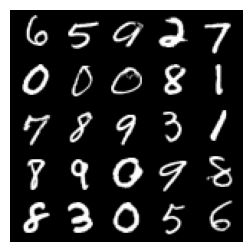

In [9]:
# DDIM samples with n_steps

n_steps = 10
sampler_name="ddim"
x0 = diffusion.prior_sampling(sampling_shape).to(config.device)
sampling_fn = sampling.get_fast_sampler(config, diffusion, model, rescaling_inv, sampler_name)
seq, seq_next = sampling.get_time_sequence(n_steps, diffusion.T, skip_type="uniform", late_t=None)
uncond_samples_ddim = sampling_fn(x0, seq, seq_next)
visualize_batch(uncond_samples_ddim[:25].cpu().clip(0,1), nrow=5, figsize=(3,5))

## Score estimation

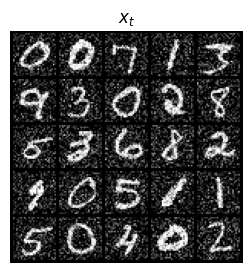

In [10]:
# generated a noisy state for a given time \in [0,T=1000]
t = 150
timesteps = torch.ones(x.shape[0], dtype=torch.int64, device=device) * t

# conditional probability $x_t \sim  p(x_t|x_0)$
x_t, noise = diffusion.t_forward_steps(x.to(device), timesteps)
visualize_batch(rescaling_inv(x_t[:25]).cpu().clamp(0,1), title='$x_t$', nrow=5, figsize=(3,5))

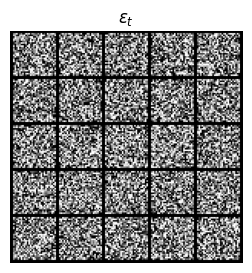

In [11]:
with torch.no_grad():
    predicted_noise = model(x_t, timesteps)

visualize_batch(rescaling_inv(predicted_noise[:25]).cpu().clamp(0,1), title=f'$\\epsilon_t$', nrow=5, figsize=(3,5))

In [12]:
sqrt_1m_alphas_cumprod = diffusion.sqrt_1m_alphas_cumprod.to(config.device)

In [13]:
score = - predicted_noise / sqrt_1m_alphas_cumprod[timesteps, None, None, None]